In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt

from scipy import stats as st

import seaborn as sns

#для работы с datetime сеткой
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

In [2]:
'''место для общих технических функций'''

'''показать счетчики значений по списку колонок'''
def value_counts_func (df, Columns):
    for Column in Columns:
        print (Column)
        print (df[Column].value_counts(dropna=False))
        print ('=======================================')

### Загрузка и обзор данных

In [3]:
visits_df = pd.read_csv('/datasets/visits_log.csv', nrows=5)
orders_df = pd.read_csv('/datasets/orders_log.csv', nrows=5)
costs_df = pd.read_csv('/datasets/costs.csv', nrows=5)

for df in [visits_df, orders_df, costs_df]:
    print (df)
    

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06

загружается норм, альтернативных сепараторов не надо. Загружаем полные сеты:

In [4]:
visits_df = pd.read_csv('/datasets/visits_log.csv')
orders_df = pd.read_csv('/datasets/orders_log.csv')
costs_df = pd.read_csv('/datasets/costs.csv')

In [5]:
for df in [visits_df, orders_df, costs_df]:
    df.info()
    print('======================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [6]:
value_counts_func(visits_df, ['Device', 'Source Id'])

Device
desktop    262567
touch       96833
Name: Device, dtype: int64
Source Id
4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64


In [7]:
value_counts_func(costs_df, ['source_id'])

source_id
5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64


In [8]:
for df in [visits_df, orders_df, costs_df]:
    print (df[df.duplicated()])

Empty DataFrame
Columns: [Device, End Ts, Source Id, Start Ts, Uid]
Index: []
Empty DataFrame
Columns: [Buy Ts, Revenue, Uid]
Index: []
Empty DataFrame
Columns: [source_id, dt, costs]
Index: []


По результатам первичного осмотра можно заключить следующее:
- необходимо произвести переименования таблиц для удобства и единообразия;
- timestamp столбцы необходимо привести к виду datetime, остальные - к подходящему (категории, строки, int, float)
- дубликаты и пропуски не обнаружены.

## Обработка данных и приведение типов

In [9]:
#переименовываем столбцы  там, где надо:
visits_df.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders_df.columns = ['buy_ts', 'revenue', 'uid']

In [10]:
costs_df.head(5)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [11]:
for column in ['end_ts', 'start_ts']:
    visits_df[column] = pd.to_datetime(visits_df[column], format='%Y-%m-%d %H:%M:%S')

In [12]:
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [13]:
costs_df['dt'] = pd.to_datetime(costs_df['dt'], format='%Y-%m-%d')

То, как используются float и int меня устраивает, еще хочется device переделать в category - типов всего два, это бессмысленная трата памяти. На визуализациях вряд ли вылезет (если вылезет, вернем обратно или подберем решение).

In [14]:
visits_df['device'] = visits_df.device.astype('category')

In [15]:
for df in [visits_df, orders_df, costs_df]:
    df.info()
    print('======================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Мы переименовали столбцы, поправили типы данных, датасеты готовы к анализу.

### Аналитика продукта

Для начала расчитаем базовые метрики: среднюю аудиторию, "липкий" фактор, и посмотрим на аудиторию в разрезе по платформам и источникам:

In [16]:
visits_df['session_month'] = visits_df.start_ts.astype('datetime64[M]')
visits_df['session_day'] = visits_df.start_ts.astype('datetime64[D]')
visits_df['session_week'] = visits_df.start_ts.astype('datetime64[D]') - pd.to_timedelta(visits_df.start_ts.dt.dayofweek, unit='d')


In [17]:
metric_dict = {'session_month' : "месячная (MAU)", 'session_week': "недельная (WAU)", 'session_day' : "ежедневная (DAU)"}
AU={}
for metric in metric_dict:
    AU[metric] = float(visits_df.groupby(metric).agg({'uid':'nunique'}).mean())
    print('средняя', metric_dict[metric], 'аудитория:' ,int(AU[metric]) , 'человек')
    print('----------------------------')

средняя месячная (MAU) аудитория: 23228 человек
----------------------------
средняя недельная (WAU) аудитория: 5716 человек
----------------------------
средняя ежедневная (DAU) аудитория: 907 человек
----------------------------


У меня отсутствует точка отчёта, чтобы сравнить, но нельзя сказать, что количество уникальных пользователей особенно большое.

In [18]:
sticky_factor_w =  AU['session_day'] / AU['session_week']
sticky_factor_m =  AU['session_day'] / AU['session_month']
print ('Sticky factor (месячный) равен', round(sticky_factor_m,3))
print('----------------------------')
print ('Sticky factor (недельный) равен', round(sticky_factor_w,3))

Sticky factor (месячный) равен 0.039
----------------------------
Sticky factor (недельный) равен 0.159


Выглядит как очень низкий показатель лояльности пользователей: пользователи заходят на сайт очень нерегулярно (грубо говоря, только 4% заходят каждый день, и 16% - раз в неделю). 
Найденные в сети материалы подтверждают, что данные показатели далеки не только от хороших, но даже от средних.

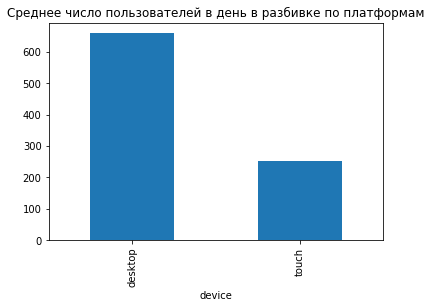

In [19]:
visits_df.pivot_table(index='device', columns = 'session_day', values= 'uid', aggfunc='nunique').T.mean().plot(kind='bar', title ='Среднее число пользователей в день в разбивке по платформам')

Пользователей, которые заходят на сайт с компьютера, почти в два с половиной раза больше, чем мобильных устройств.

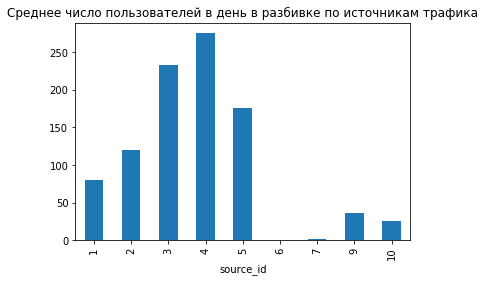

In [20]:
visits_df.pivot_table(index='source_id', columns = 'session_day', values= 'uid', aggfunc='nunique').T.mean().plot(kind='bar', title ='Среднее число пользователей в день в разбивке по источникам трафика')

Выделяется 
- три эффективных источника трафика - 3,4,5,
- один промежуточный (больше сотни, но не дотягивает на первой тройки сильно) - 2;
- слабые -1, 9 и 10,
- и совсем аутсайдеры - 6, 7. 

Построим график числа пользователей в день в разбивке по платформам:

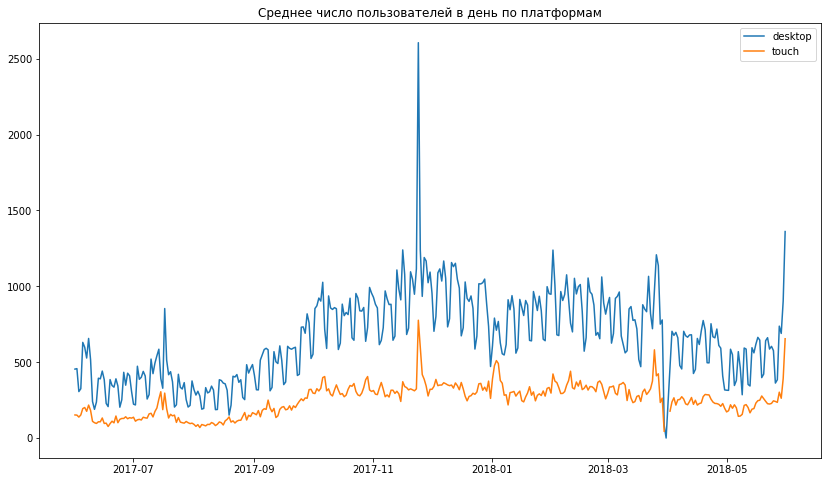

In [21]:
visits_daily = visits_df.pivot_table(index='session_day', columns = 'device', values= 'uid', aggfunc='nunique')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
ax1.set_title('Среднее число пользователей в день по платформам')
ax1.plot(visits_daily)
ax1.legend(visits_daily.columns)

Дневной график получается шумным, построим недельный:

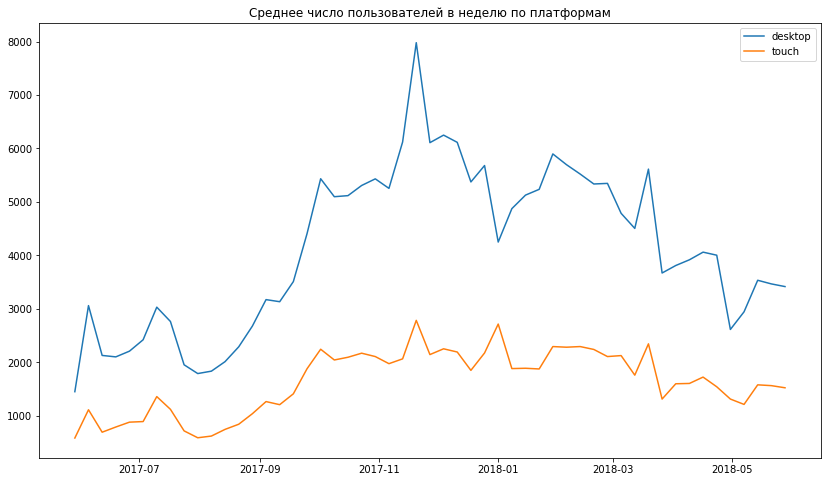

In [22]:
visits_weekly = visits_df.pivot_table(index='session_week', columns = 'device', values= 'uid', aggfunc='nunique')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
ax1.set_title('Среднее число пользователей в неделю по платформам')
ax1.plot(visits_weekly)
ax1.legend(visits_weekly.columns)

На недельном графике тенденции лучше видны: очевидно, что в 2017г. число пользователей росло, выйдя на пик в ноябре-декабре, а затем начало падать, причем на ПК падение заметно более резкое, чем на мобильных девайсах. 

Сделаем также разбивку по каналам привлечения. Возьмем каналы 2,3,4,5 как те, по которым приходит существенное количество пользователей (более ста). Также с учетом большого количество линий трендов на одном поле построим с группировкой по месяцам:

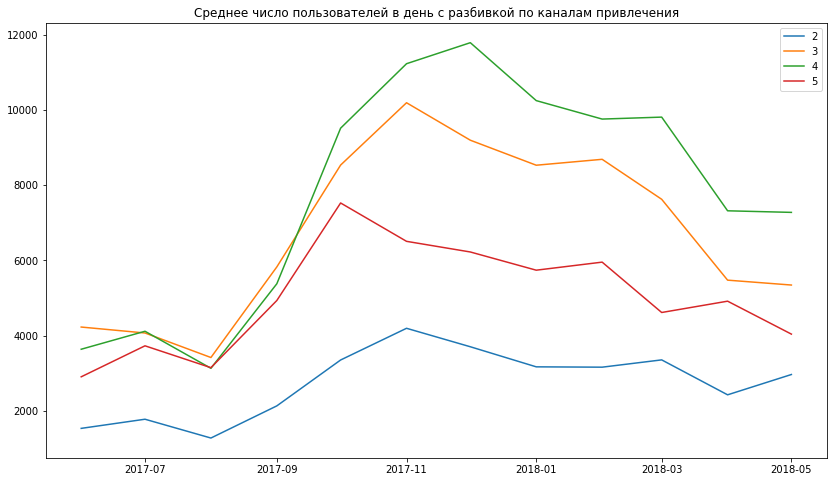

In [23]:
visits_daily_by_source = visits_df.pivot_table(index='source_id', columns = 'session_month', values= 'uid', aggfunc='nunique')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
ax1.set_title('Среднее число пользователей в день с разбивкой по каналам привлечения')
ax1.plot(visits_daily_by_source.T[[2,3, 4, 5]])
ax1.legend([2,3, 4, 5])

Тенденции схожие, можно только заметить, что чем больше канал, тем более волатильно он отвечает на общий тренд.

### Анализ сессий

Расчитаем число уникальных пользователей и количество сессий. Для определения общей метрики - количество сессий в день - определим общее количество сессий и пользователей.

In [24]:
sessions = visits_df.groupby('session_day').agg({'uid':'nunique', 'start_ts':'count'})
sessions.columns = ['n_users', 'n_sessions']
sessions['avg'] = sessions.n_sessions / sessions.n_users

In [25]:
avg_sessions = sessions.sum().n_sessions / sessions.sum().n_users
print('В среднем пользователь в день совершает {:.2f} сессий'.format(avg_sessions))

В среднем пользователь в день совершает 1.09 сессий


In [26]:
for device in np.sort(visits_df.device.unique()):
    sessions = visits_df[visits_df.device==device].groupby('session_day').agg({'uid':'nunique', 'start_ts':'count'})
    sessions.columns = ['n_users', 'n_sessions']
    sessions['avg'] = sessions.n_sessions / sessions.n_users
    avg_sessions = sessions.sum().n_sessions / sessions.sum().n_users
    print('Среднее число сессий на платформе', device, ': {:.2f}'.format(avg_sessions))
    print('-----------------------------------')

Среднее число сессий на платформе desktop : 1.09
-----------------------------------
Среднее число сессий на платформе touch : 1.05
-----------------------------------


In [27]:
np.sort(visits_df.source_id.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10])

In [28]:
for source in np.sort(visits_df.source_id.unique()):
    sessions = visits_df[visits_df.source_id==source].groupby('session_day').agg({'uid':'nunique', 'start_ts':'count'})
    sessions.columns = ['n_users', 'n_sessions']
    sessions['avg'] = sessions.n_sessions / sessions.n_users
    avg_sessions = sessions.sum().n_sessions / sessions.sum().n_users
    print('Среднее число сессий по каналу привлечения', source, ': {:.2f}'.format(avg_sessions))
    print('-----------------------------------')

Среднее число сессий по каналу привлечения 1 : 1.16
-----------------------------------
Среднее число сессий по каналу привлечения 2 : 1.09
-----------------------------------
Среднее число сессий по каналу привлечения 3 : 1.01
-----------------------------------
Среднее число сессий по каналу привлечения 4 : 1.02
-----------------------------------
Среднее число сессий по каналу привлечения 5 : 1.05
-----------------------------------
Среднее число сессий по каналу привлечения 6 : 1.00
-----------------------------------
Среднее число сессий по каналу привлечения 7 : 1.00
-----------------------------------
Среднее число сессий по каналу привлечения 9 : 1.01
-----------------------------------
Среднее число сессий по каналу привлечения 10 : 1.06
-----------------------------------


Дневные метрики получаются шумные, посмотрим хотя бы на усредненные по неделям:

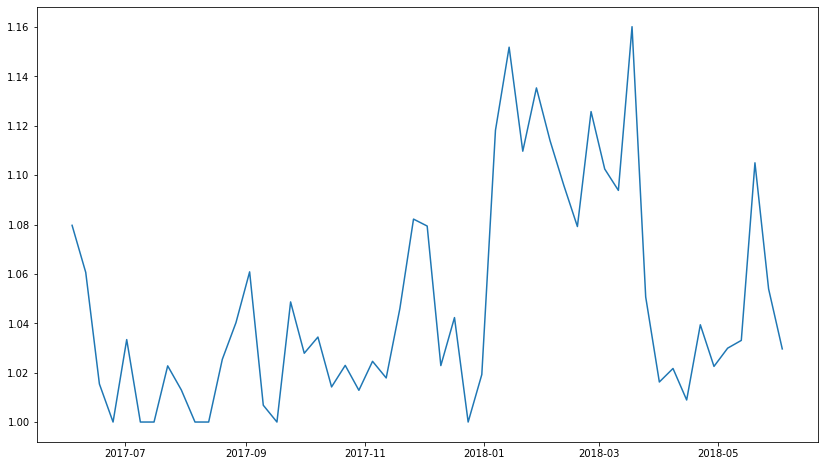

In [29]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
ax1.plot(sessions['avg'].resample('W').mean())

Интересно, что обычно довольно невысокое среднее количество сессий заметно выросло в первом квартале 2018 г. Интересно, связано ли это с сезонностью как-либо (плохая погода, люди ищут, куда пойти) или с чем-то еще.

Посчитаем ASL - среднюю продолжительность сессии:

In [30]:
visits_df['session_length'] = (visits_df['end_ts'] - visits_df['start_ts']).dt.seconds

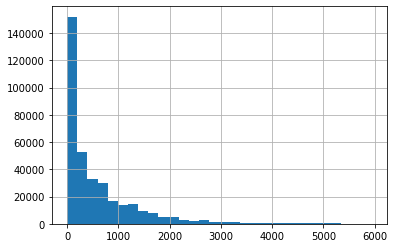

In [31]:
#ограничим длинну сессии 6к, чтобы хоть что-то видеть на графике
visits_df[visits_df.session_length<6000].session_length.hist(bins=30)

Огромное количество сессий очень коротки - люди заходят ненадолго, не видят ничего интересного, и покидают сайт. 
Похоже, при таком распределении имеет смысл посмотреть на модальные значения.

In [32]:
for source in [2,3,4,5]:
    print('У источника {} следующие модальные значения:'.format(source))
    print(visits_df[visits_df.source_id==source]['session_length'].mode())
    print('---------------')

У источника 2 следующие модальные значения:
0    60
dtype: int64
---------------
У источника 3 следующие модальные значения:
0    60
dtype: int64
---------------
У источника 4 следующие модальные значения:
0    60
dtype: int64
---------------
У источника 5 следующие модальные значения:
0    60
dtype: int64
---------------


In [33]:
visits_df.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_day,session_week,session_length
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-20,2017-12-18,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-19,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-26,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-20,2018-05-14,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-27,2017-12-25,0


In [34]:
for device in np.sort(visits_df.device.unique()):
    print('По платформе {} следующие модальные значения:'.format(device))
    print(visits_df[visits_df.device==device]['session_length'].mode())
    print('---------------')

По платформе desktop следующие модальные значения:
0    60
dtype: int64
---------------
По платформе touch следующие модальные значения:
0    60
dtype: int64
---------------


Модальное значение по платформам и источникам трафика не различается и составляет 1 минуту.

Чтобы ответить на вопрос "как часто возвращаются пользователи", рассчитаем retention rate. 

In [35]:
visits_df.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid', 'session_month',
       'session_day', 'session_week', 'session_length'],
      dtype='object')

In [36]:
first_visit = visits_df.groupby(['uid'])['session_month'].min()
first_visit.name = 'first_session_month'
visits_df = visits_df.join(first_visit,on='uid')

In [37]:
visits_df['lifetime'] = visits_df.session_month - visits_df.first_session_month
visits_df['lifetime'] = (visits_df['lifetime'] / np.timedelta64(1,'M')).round().astype('int')

In [38]:
visits_df

,device,end_ts,source_id,start_ts,uid,session_month,session_day,session_week,session_length,first_session_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-20,2017-12-18,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-19,2018-02-19,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-26,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-20,2018-05-14,1440,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-27,2017-12-25,0,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-01,2017-07-29,2017-07-24,19,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-25,2018-01-22,19,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-01,2018-03-03,2018-02-26,19,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-01,2017-11-02,2017-10-30,19,2017-11-01,0


In [39]:
cohorts = visits_df.groupby(['first_session_month','lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_session_month,lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [40]:
initial_users = cohorts[cohorts.lifetime==0][['first_session_month', 'uid']]
initial_users.columns = ['first_session_month', 'initial_users']

In [41]:
cohorts = cohorts.merge(initial_users, on = 'first_session_month')
cohorts

,first_session_month,lifetime,uid,initial_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [42]:
cohorts['retention_rate'] = cohorts.uid / cohorts.initial_users

In [43]:
cohorts_pivot = cohorts.pivot(index = 'first_session_month', columns = 'lifetime', values = 'retention_rate')
cohorts_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


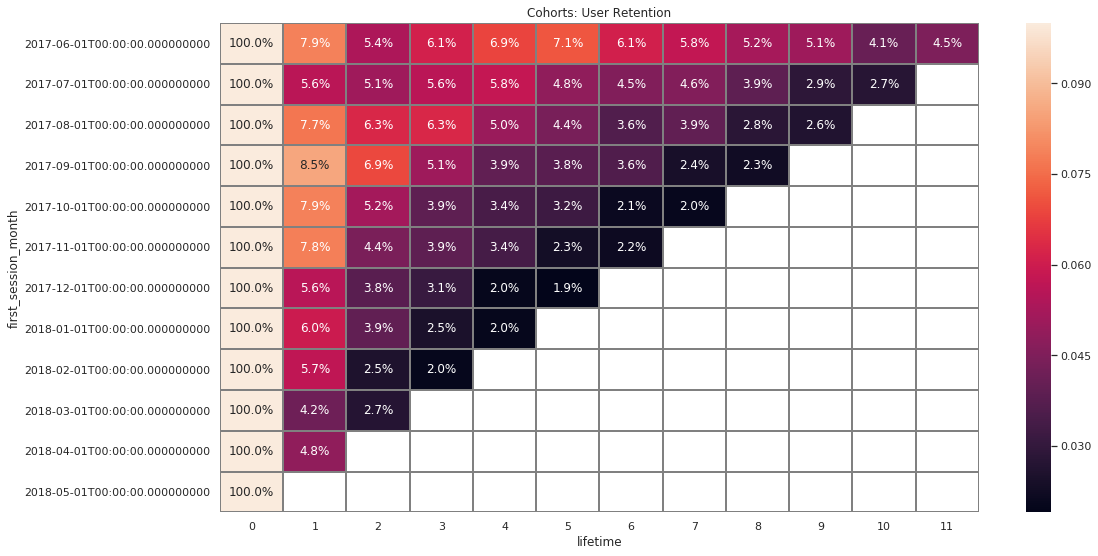

In [44]:
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(cohorts_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1)

## Промежуточные выводы по продукту

Продукт не самый популярный сам по себе, метрики показывают слабую лояльность пользователей, за исключением, пожалуй, первых когорт (лето 2017 г.), где ситуация чуть-чуть получше, хотя в целом ситуация далека от хорошей.
При этом наметился и очевидный тренд на снижение показателей: число пользователей и коэффициент удержания заметно падает последние периоды. Необходимо анализировать, в чем проблемы пользователей, почему они показывают такое поведение, и принимать конструктивные попытки изменить ситуацию.

### Изучение продаж продукта

In [45]:
orders_df.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [46]:
#создадим округления для даты
orders_df['month_order'] = orders_df.buy_ts.astype('datetime64[M]')
orders_df['week_order'] = orders_df.buy_ts.astype('datetime64[D]') - pd.to_timedelta(orders_df.buy_ts.dt.dayofweek, unit='d')

In [47]:
sales_monthly = pd.DataFrame(orders_df.groupby('month_order')['revenue'].sum())
sales_weekly = pd.DataFrame(orders_df.groupby('week_order')['revenue'].sum())

In [48]:
sales_monthly

,revenue
month_order,
2017-06-01,9557.49
2017-07-01,12539.47
2017-08-01,8758.78
2017-09-01,18345.51
2017-10-01,27987.70
2017-11-01,27069.93
2017-12-01,36388.60
2018-01-01,19417.13
2018-02-01,25560.54


Очевидно, что июнь 2018 г. необходимо отбросить, по нему фактически отсутствуют даннные

In [49]:
sales_monthly.drop(pd.Timestamp('2018-06-01'),inplace=True)
sales_monthly

,revenue
month_order,
2017-06-01,9557.49
2017-07-01,12539.47
2017-08-01,8758.78
2017-09-01,18345.51
2017-10-01,27987.70
2017-11-01,27069.93
2017-12-01,36388.60
2018-01-01,19417.13
2018-02-01,25560.54


Text(0.5, 1.0, 'общая сумма продаж по месяцам')

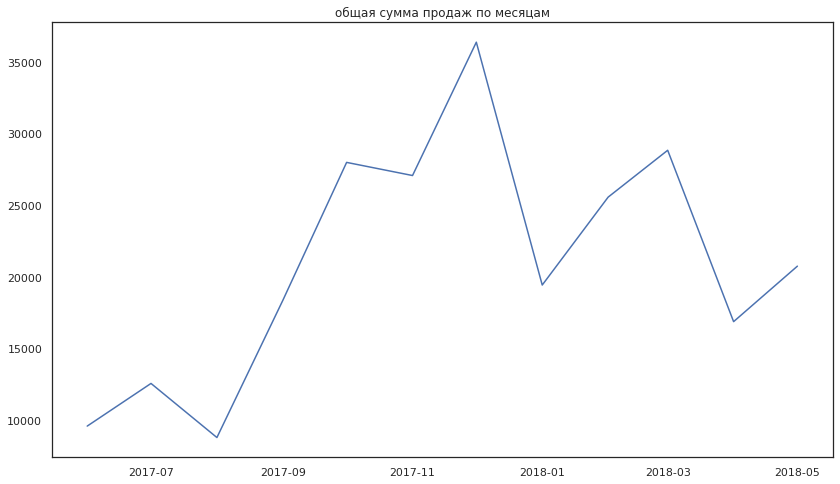

In [50]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
ax1.plot(sales_monthly)
ax1.set_title('общая сумма продаж по месяцам')

После пика в декабре 2017 г. наблюдается тренд на снижение продаж, хотя и сезонность оказывает заметное влияние, от месяца к месяцу продажи сильно отличаются. 

Для ответа на вопрос "когда люди начинают покупать" - объединим данные visits и orders, чтобы понять, какое время проходит между первым посещением сайта и первой покупкой. Возьмем день первой сессии из visits и день первого заказа из orders.

In [51]:
orders_df['order_day'] = orders_df.buy_ts.astype('datetime64[D]')
orders_df.head()

,buy_ts,revenue,uid,month_order,week_order,order_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-05-29,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-05-29,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-05-29,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-05-29,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-05-29,2017-06-01


In [52]:
first_visit_day = pd.DataFrame(visits_df.groupby(['uid'])['session_day'].min())
first_buy_day = pd.DataFrame(orders_df.groupby(['uid'])['order_day'].min())

In [53]:
print(len(first_visit_day))
print(len(first_buy_day))

228169
36523


In [54]:
First_orders_df = first_visit_day.merge(first_buy_day, how='inner', on='uid')

In [55]:
First_orders_df.head()

,session_day,order_day
uid,,
313578113262317,2017-09-18,2018-01-03
1575281904278712,2017-06-03,2017-06-03
2429014661409475,2017-10-11,2017-10-11
2464366381792757,2018-01-27,2018-01-28
2551852515556206,2017-11-24,2017-11-24


In [56]:
First_orders_df['days_before_purchase'] = ((First_orders_df.order_day - First_orders_df.session_day) /  np.timedelta64(1,'D')).astype('int')


In [57]:
First_orders_df.days_before_purchase.describe()

count    36523.000000
mean        16.895901
std         47.071200
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: days_before_purchase, dtype: float64

Несколько очень крупных разниц, в районе года, искажают общую картину того, что люди совершают первую покупку почти сразу. Отбросим значения больше 10ти и построем гистограмму.

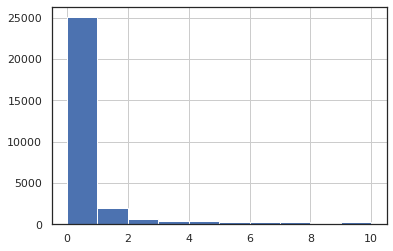

In [58]:
First_orders_df.days_before_purchase[First_orders_df.days_before_purchase <=10].hist(bins=10)

In [59]:
print('Число уникальных посетителей, всего - ', len(first_visit_day))
print('Число уникальных покупателей, всего - ', len(first_buy_day))
print('Доля посетителей, которые становятся покупателями - {:.2%}'.format(len(first_buy_day) / len(first_visit_day)))

Число уникальных посетителей, всего -  228169
Число уникальных покупателей, всего -  36523
Доля посетителей, которые становятся покупателями - 16.01%


Подавляющее большинство посетителей покупает в первую же сессию, и абсолютное большинство покупает в первую неделю. При этом общая доля покупателей в посетителях не очень большая. 
По всей видимости, первое впечатление - залог успеха, если в первые несколько дней посетителей не сталь покупателем - скорее всего, это не произойдет и далее. 

### Сколько покупают за период? Какой средний чек?

Чтобы ответить на вопрос "сколько раз покупают за период?", сгруппируем данные базы orders, по людям, по разным метрикам, и затем усредним показатель

In [60]:
orders_df.head()

,buy_ts,revenue,uid,month_order,week_order,order_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-05-29,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-05-29,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-05-29,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-05-29,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-05-29,2017-06-01


In [61]:
purchases_monthly = orders_df.groupby(['month_order']).agg({'revenue' : {'count', 'sum'}, 'uid': 'nunique' })
purchases_monthly['num'] = purchases_monthly['revenue']['count'] / purchases_monthly['uid']['nunique']
purchases_monthly['avg'] = purchases_monthly['revenue']['sum'] / purchases_monthly['uid']['nunique']
purchases_monthly

revenue               uid       num       avg
              count       sum nunique                    
month_order                                              
2017-06-01     2354   9557.49    2023  1.163618  4.724414
2017-07-01     2363  12539.47    1984  1.191028  6.320297
2017-08-01     1807   8758.78    1472  1.227582  5.950258
2017-09-01     3387  18345.51    2750  1.231636  6.671095
2017-10-01     5679  27987.70    4675  1.214759  5.986674
2017-11-01     5659  27069.93    4547  1.244557  5.953360
2017-12-01     6218  36388.60    4942  1.258195  7.363132
2018-01-01     4721  19417.13    3898  1.211134  4.981306
2018-02-01     5281  25560.54    4258  1.240254  6.002945
2018-03-01     5326  28834.59    4181  1.273858  6.896577
2018-04-01     3273  16858.06    2744  1.192784  6.143608
2018-05-01     4346  20735.98    3544  1.226298  5.851010
2018-06-01        1      3.42       1  1.000000  3.420000

In [62]:
purchases_monthly.drop(pd.Timestamp('2018-06-01'),inplace=True) #дропнем июнь, за который толком нет данных

Text(0.5, 1.0, 'общая сумма продаж по месяцам')

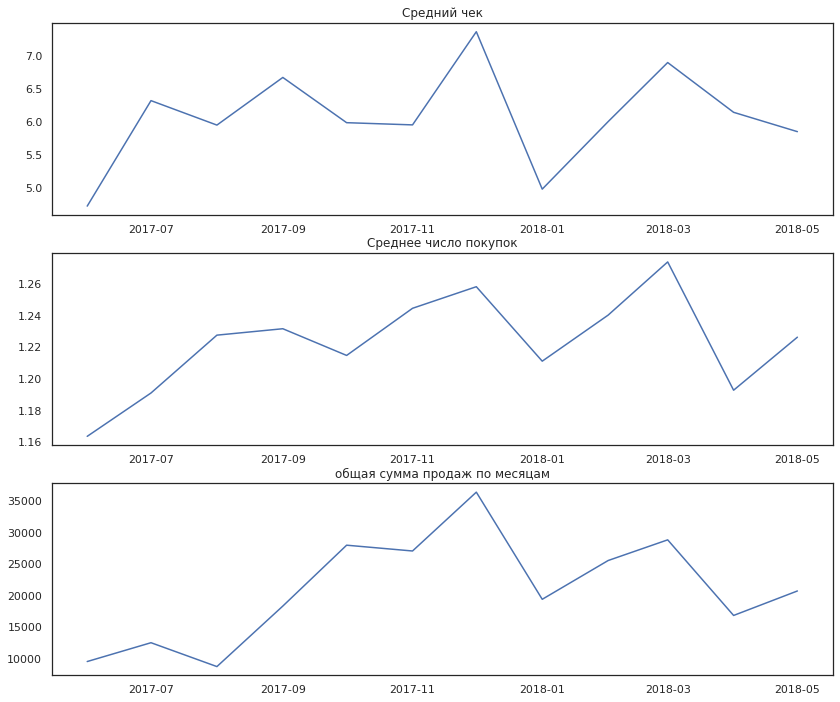

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (14,12))
ax1.plot(purchases_monthly['avg'])
ax1.set_title('Средний чек')
ax2.plot(purchases_monthly['num'])
ax2.set_title('Среднее число покупок')

#добавим данные по продажам
ax3.plot(sales_monthly)
ax3.set_title('общая сумма продаж по месяцам')

Очевидно, что средний чек и среднее число покупок сильно коррелирует с суммой продаж по месяцам.
Интересно, что пониже суммы продаж в бОльшей степени связана с понижением размера среднего чека, чем с уменьшением количества покупок: количество покупок колеблется в сравнительно узких пределах, а вот разницы между размерами среднего чека более заметны, особенно между декабрем и январем. 

Посчитаем те же метрики для недельных показателей.

In [64]:
purchases_weekly = orders_df.groupby(['week_order']).agg({'revenue' : {'count', 'sum'}, 'uid': 'nunique' })
purchases_weekly['num'] = purchases_weekly['revenue']['count'] / purchases_weekly['uid']['nunique']
purchases_weekly['avg'] = purchases_weekly['revenue']['sum'] / purchases_weekly['uid']['nunique']
purchases_weekly.head()

revenue              uid       num       avg
             count      sum nunique                    
week_order                                             
2017-05-29     340  1075.26     295  1.152542  3.644949
2017-06-05     938  2733.58     821  1.142509  3.329574
2017-06-12     343  2020.39     317  1.082019  6.373470
2017-06-19     371  1790.59     339  1.094395  5.281976
2017-06-26     460  2407.44     411  1.119221  5.857518

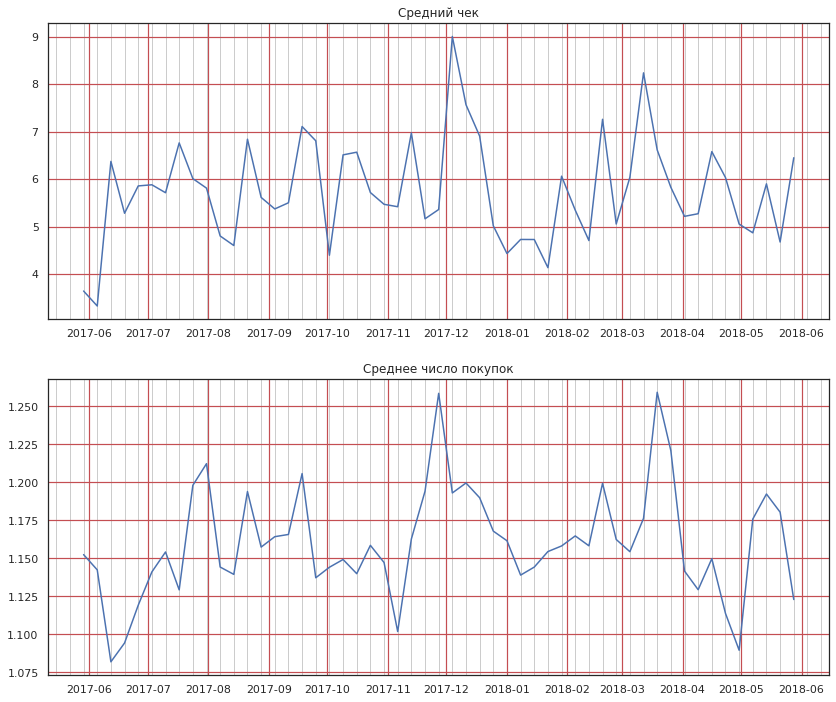

In [65]:
months = mdates.MonthLocator()  # every month
weeks = mdates.WeekdayLocator(byweekday=MO, interval=1)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (14,12))
ax1.plot(purchases_weekly['avg'])
ax1.set_title('Средний чек')
ax2.plot(purchases_weekly['num'])
ax2.set_title('Среднее число покупок')
for ax in [ax1, ax2]:
    ax.xaxis.grid(True, which='minor')
    ax.grid(axis = 'both')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_minor_locator(weeks)
    
    ax.grid(which='major',
        color = 'r',
        linewidth = 1.2)


Недельные графики кажутся более шумными, но в них можно увидеть резкие скачки, явно связанные с сезонностью и, возможно, с располагаемым доходом. Особенно хорошо заметны:
- пики среднего чека и числа покупок под новый год;
- провал количества покупок на майские;
- пики в первом квартале напоминают о праздниках - 23 февраля, 8 марта. 
- некоторые иные скачки могут быть следствием погоды, расчетных дат или каких-то иных факторов, общих для клиентов.

### расчитываем LTV 

In [66]:
orders_df.head()

,buy_ts,revenue,uid,month_order,week_order,order_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-05-29,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-05-29,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-05-29,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-05-29,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-05-29,2017-06-01


In [67]:
#выделяем месяц первого заказа
first_orders = orders_df.groupby('uid').agg({'month_order': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [68]:
#определяем размер когорт
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [69]:
#группируем выручку по когортам помесячно и добавляем даннные о размере каждой когорты
orders_df = orders_df.merge(first_orders, on ='uid')
cohorts = orders_df.groupby(['first_order_month','month_order']).agg({'revenue': 'sum'}).reset_index()

cohorts = cohorts.merge(cohort_sizes, on='first_order_month') 

Маржинальность мы считаем равной единице (комментарий наставника), т.е. этот этап мы пропускаем.

In [70]:
cohorts['age'] = ((cohorts['month_order'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [71]:
#расчитываем LTV на данных о выручке и числе покупателей в когорте, и формируем сводную таблицу по lifetime
cohorts['ltv'] = cohorts['revenue'] / cohorts['n_buyers']
final_pivot = cohorts.pivot_table(index='first_order_month', columns='age', values='ltv',aggfunc='mean').round(2)
final_pivot.cumsum(axis=1).round(2).fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


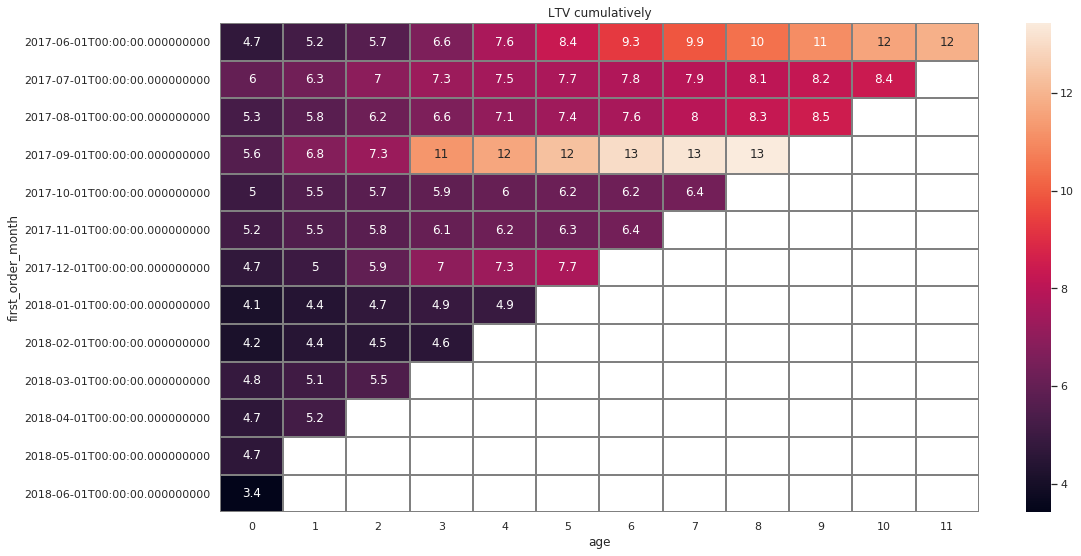

In [72]:
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('LTV cumulatively')
sns.heatmap(final_pivot.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray')

Интересно, похоже получается, что в первый месяц все когорты приносят весьма значительную долю LTV, после чего показатель резко снижается. Похоже, это связано со значительным оттоком пользователей из когорт в целом. При этом в  новых когортах LTV показывает тенденцию к снижению. 

### Аналитика маркетинга

Сколько денег потратили? Всего / на каждый источник / по времени
Сколько стоило привлечение одного покупателя из каждого источника?
На сколько окупились расходы? (ROI)

Чтобы ответить на первый вопрос - сколько денег потратили, в разрезе по источникам и по времени - построим разные группировки массива по расходам.

In [73]:
print(' Всего потратили {:.2f} единиц средств.'.format(costs_df.costs.sum()))

 Всего потратили 329131.62 единиц средств.


In [74]:
costs_by_source = costs_df.groupby('source_id')['costs'].sum()
costs_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

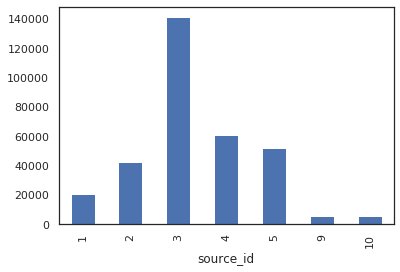

In [75]:
costs_by_source.plot(kind='bar')

In [76]:
costs_df['month'] = costs_df['dt'].astype('datetime64[M]')
costs_df['week'] = costs_df['dt'].astype('datetime64[D]') - pd.to_timedelta(costs_df['dt'].dt.dayofweek, unit='d')

In [77]:
costs_by_week = costs_df.groupby('week')['costs'].sum()
costs_by_month = costs_df.groupby('month')['costs'].sum()

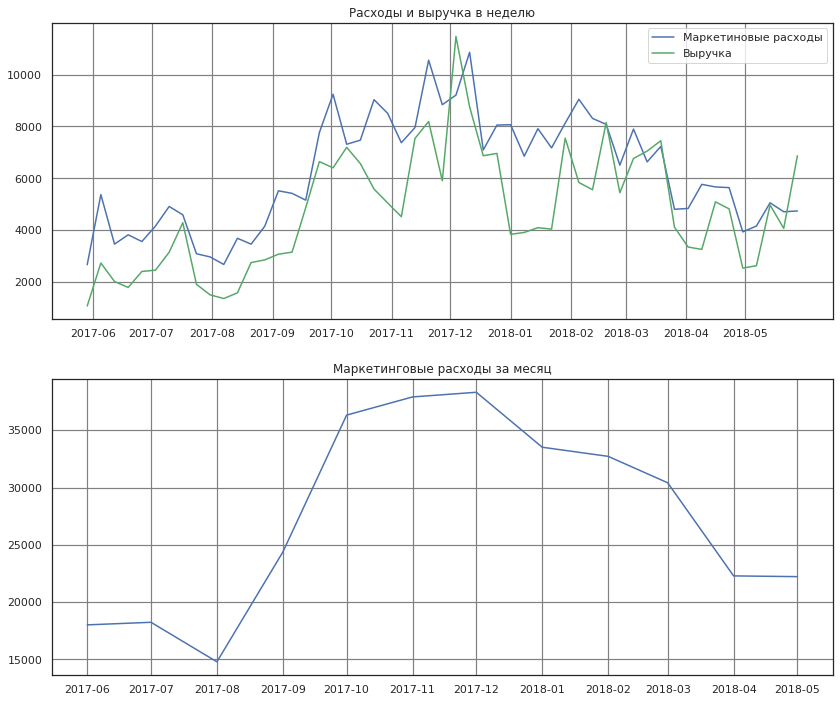

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (14,12))
ax1.plot(costs_by_week)
ax1.plot(sales_weekly, color = 'g')
ax1.set_title('Расходы и выручка в неделю')

ax1.legend (['Маркетиновые расходы', 'Выручка'])
ax2.plot(costs_by_month)
ax2.set_title('Маркетинговые расходы за месяц')

for ax in [ax1, ax2]:
    #ax.xaxis.grid(True, which='minor')
    ax.grid(axis = 'both')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_minor_locator(weeks)
    
    ax.grid(which='major',
        color = 'grey',
        linewidth = 1.2)

Кажется, все не очень хорошо: вливаниями маркетинового бюджета мы стимулируем первую продажу, но затем почти все покупатели уходят. По графику заметно, что фактически на маркетинг мы тратим даже больше, чем зарабатываем на продажах.

**Сколько стоило привлечение одного покупателя из каждого источника?**

Для этого сгруппируем данные о покупателях, считая, что первый источник покупки является основным источником привлечения данного клиента. При этом данные об источниках трафика у нас есть только в данных посещений, так что нам предстоит объединить данные.

In [79]:
visits_df.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_day,session_week,session_length,first_session_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-20,2017-12-18,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-19,2018-02-19,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-26,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-20,2018-05-14,1440,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-27,2017-12-25,0,2017-12-01,0


In [80]:
buyers_list = orders_df.uid.unique() #выделим переченм uid пользователей, которые за наблюдаемый период стали нашими покупателями

In [81]:
buyers_visits = visits_df[visits_df.uid.isin(buyers_list)] #отберем посетителей, которые стали покупателями

In [82]:
buyers_visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_day,session_week,session_length,first_session_month,lifetime
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-20,2018-05-14,1440,2018-03-01,2
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-01,2017-09-03,2017-08-28,60,2017-09-01,0
12,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018-02-01,2018-02-06,2018-02-05,300,2017-06-01,8
15,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018-02-01,2018-02-12,2018-02-12,3960,2018-02-01,0
25,desktop,2017-12-05 10:28:00,4,2017-12-05 10:21:00,2307401184189569202,2017-12-01,2017-12-05,2017-12-04,420,2017-09-01,3


In [83]:
buyers_visits = buyers_visits.sort_values('start_ts') 
#отсортировали данные по дате начала сессии. Теперь при группировке по uid строки также будут отсортированы, и мы сможем 
#использовать "n-ый в массиве" для определения самого первого источника трафика. Я проверил глазами, это сработало.

In [84]:
first_source = buyers_visits.groupby('uid')['source_id'].nth(0).reset_index()

In [85]:
buyers_first_source_grouped = first_source.groupby('source_id')['uid'].count().reset_index()
buyers_first_source_grouped

,source_id,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


Мы получили данные о том, сколько уникальных покупателей пришло из разных источников. Осталось объединить эту информацию с данными о группировке расходов по источникам, и мы увидим стоимость привлечения.

In [86]:
costs_by_source = costs_by_source.reset_index()

In [87]:
costs_by_source = costs_by_source.merge(buyers_first_source_grouped, on='source_id', how = 'outer')


In [88]:
costs_by_source['cost_per_user'] = costs_by_source['costs'] / costs_by_source['uid']

In [89]:
costs_by_source

,source_id,costs,uid,cost_per_user
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106
7,7,NaN,1,NaN


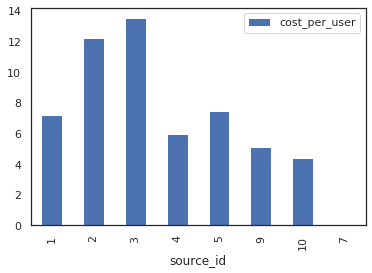

In [90]:
costs_by_source.plot(y = 'cost_per_user', x = 'source_id', kind='bar')

Мы получили стоимость привлечения. Источники 2 и 3, которые мы причислили ко второму эшелону, оказались исключительно дорогими в расчете на пользователя. 

#### На сколько окупились расходы? (ROI)

Для этого нам нужно:
- совместить данные о продажах с данными об источнике привлечения клиента;
- посчитать LTV в разбивке по источникам;
- поделить на CAC - посчитанную среднюю стоимость привлечения.

In [91]:
orders_df = orders_df.merge(first_source, on ='uid') #добавляем в данные о заказах информацию об источнике привлечения покупателя
orders_df.head()

,buy_ts,revenue,uid,month_order,week_order,order_day,first_order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-05-29,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-05-29,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-05-29,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-05-29,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-05-29,2017-06-01,2017-06-01,3


In [92]:
cohorts = orders_df.groupby(['source_id', 'first_order_month','month_order']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,source_id,first_order_month,month_order,revenue
0,1,2017-06-01,2017-06-01,1378.70
1,1,2017-06-01,2017-07-01,414.98
2,1,2017-06-01,2017-08-01,419.43
3,1,2017-06-01,2017-09-01,714.24
4,1,2017-06-01,2017-10-01,811.20


In [93]:
cohorts = cohorts.merge(costs_by_source[['source_id', 'uid', 'cost_per_user' ]], on='source_id') 

In [94]:
cohorts['age'] = ((cohorts['month_order'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [95]:
cohorts['ltv'] = cohorts['revenue'] / cohorts['uid']

In [96]:
cohorts['romi'] = cohorts['ltv'] / cohorts['cost_per_user'] #cost_per_user = CAC

In [97]:
#нужно проссумировать romi по источникам и возрасту, потому что внутренняя разбивка по когортам сбивает приборы
cohorts_grouped = cohorts.groupby(['source_id', 'age']).agg({'romi':sum})

In [98]:
output = cohorts_grouped.pivot_table(
        index='source_id', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output_accum = output.cumsum(axis=1).round(2)
output_accum.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.87,1,1.11,1.21,1.26,1.3,1.34,1.39,1.43,1.46,1.48,1.49
2,0.54,0.66,0.79,0.92,0.98,1.02,1.05,1.07,1.08,1.08,1.09,1.1
3,0.33,0.35,0.36,0.37,0.38,0.38,0.38,0.38,0.38,0.39,0.39,0.39
4,0.77,0.8,0.82,0.84,0.85,0.87,0.9,0.91,0.91,0.92,0.93,0.93
5,0.65,0.68,0.71,0.91,0.94,0.97,0.99,1,1.01,1.01,1.02,1.02
7,0.00,,,,,,,,,,,
9,0.77,0.82,0.88,0.92,0.95,0.98,1,1.01,1.04,1.04,1.04,
10,0.72,0.74,0.74,0.75,0.76,0.76,0.76,0.76,0.76,0.76,,


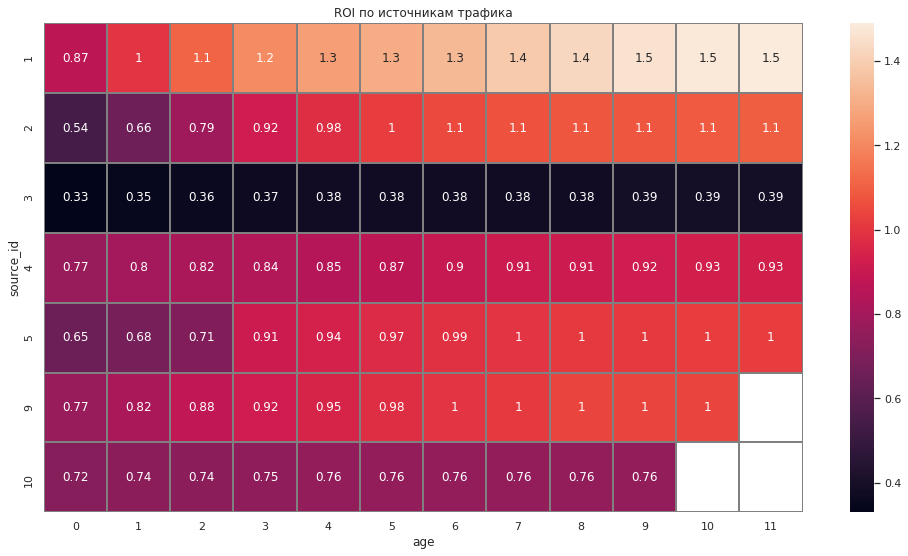

In [99]:
#построим heatmap, убрав 7 источник трафика
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('ROI по источникам трафика')
sns.heatmap(output_accum.drop(7), annot=True, linewidths=1, linecolor='gray')

Лучше всего окупаются источники трафика №1 и №2. Наш самый крупный источник трафика - №4 - так и не выходит на окупаемость, хотя ROI стремиться к 1. А вот источник трафика №3, на который нас приходится наибольшая часть расходов, даже не приближается к тому, чтобы окупиться.

## Общий вывод и рекомендации 
Наших данных недостаточно для полноценных маркетинговых выводов: поведение пользователей меняется в зависимости от того, сколько средств вкладывается в тот или иной источник, нельзя считать, что полученные выводы можно линейно масштабировать (направив весь маркетинговый ресурс на источник трафика №1, мы совершенно не обязательно продолжим получать окупаемость на 2 месяц). Однако с достаточной степенью уверенности можно говорить следующее:

У проекта большие проблемы с удержанием пользователей, причем проблема заметно усугубляется со временем. Возможно, проект не решает задачи пользователя - быстро решить, как провести время - и те покидают ресурс, не найдя ничего интересного. Низкое среднее время сессии можно интерпретировать и как отсутствие интереса к предлагаемым опциям, и как признак того, что в принципе ресурс не работает на решение задач потребителя.

Количество пользователей постепенно уменьшается, и проект поддерживается за счёт постоянного вливания бюджета и привлечения новых покупателей: мало кто становится постоянным пользователем. Вероятно, следует сосредоточиться на удержании пользователей на более долгое время и на превращении первых покупателей в постоянных потребителей. Если человек совершил покупку, значит он зарегистрировался и оставил о себе контактные данные: email, телефон, другую информацию. Возможно, пустив часть маркетингового бюджета на то, чтобы вернуть покупателей (с помощью промокодов, специальных предложений и т.д.), можно выиграть больше, чем за счёт привлечения новых клиентов. 

По платформам: desktop остается основной платформой со значительным перевесом. Возможно это связано с тем, как люди пользуются сервисом, или с какими-то неудобствами мобильной версии, но графики о платформах говорят об отсутствии каких-либо значимых тенденций. Мобильные платформы, вероятно, следует исследовать и развивать, но desktop остается платформой, которая поддерживает сервис в рабочем состоянии.

По общим тенденциям: сервис очевидно подвержен сезонности. Можно попробовать провести сравнительный анализ с другими сервисами и установить, насколько он чувствителен к различным факторам, и как на это можно реагировать - имеет ли смысл интенсивней менять контент, по разному подходить к финансированию сервиса в различных сезонах и т.д.

По источникам трафика:
- источник трафика №3 - черная дыра, поглощающая маркетинговый бюджет. Расходы на него стоит очень значительно урезать или отказаться от него вовсе.
- ресурсы трафика №4 следует в значительной степени перераспределить по другим источникам (например направить на №1 и №2). Это самый массовый источник, но он не выходит на окупаемость даже на годовом промежутке; 
- источник трафика №1 имеет отличный ROI, можно определенно вкладываться в него значимой долей бюджета. Второй на очереди - источник №2. 
- источники №9 и 10 могут быть перспективными из-за сравнительно низкой стоимости привлечения. Если удастся решить проблему удержания пользователей, то они могут стать адекватными "консервативными" вложениями на балансировки маркетингового портфеля.

